In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# to make this notebook's output stable across runs.
np.random.seed(42)
tf.random.set_seed(42) # reseta gerador de sequências PN da biblioteca Tensorflow.

### Carregando o conjunto de dados fashion MNIST. 

+ O Keras tem várias funções para carregar conjuntos de dados populares em `keras.datasets`. 


+ O conjunto total de dados já está dividido em conjuntos de treinamento e de teste.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print('Treinamento:', len(y_train_full))
print('Teste:', len(y_test))

Treinamento: 60000
Teste: 10000


+ Na sequência, dividimos o conjunto de treinamento em um conjunto de validação e um conjunto de treinamento (menor).
    + 5000 exemplos para validação e 55000 para treinamento.


+ Também **escalonamos** as magnitudes dos pixels para o intervalo de 0-1 e as convertemos em floats, dividindo por 255.

In [4]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test / 255.

print('Validação:', len(y_valid))
print('Treinamento:', len(y_train))

Validação: 5000
Treinamento: 55000


Plotando algumas imagens do banco de dados.

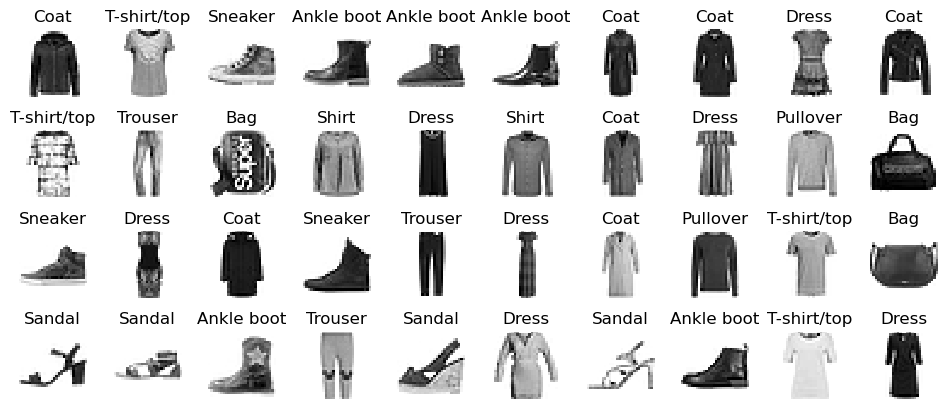

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Criando um modelo sequencial

O modelo abaixo é o de um **classificador MLP com duas camadas ocultas**. Na sequência, descrevemos cada uma das linhas de código da célula abaixo.

+ A primeira linha cria um modelo Sequencial.
+ A primeira cadamda é uma camada `Flatten` cuja função é simplesmente converter cada imagem de entrada ($28 \times 28$) em uma array 1D. 
    + Esta camada não possui parâmetros, faz apenas um pré-processamento simples de conversão de dimensões.
    + Por ser a primeira camada do modelo, devemos especificar o parâmetro `input_shape`. **Ele não inclui o tamanho do mini-batch**, apenas as dimensões dos exemplos de entrada.
+ Em seguida, adicionamos uma camada oculta densa (i.e., classe `Dense`) com 300 neurônios. Ele usará a função de ativação **ReLU**.
+ Em seguida, adicionamos uma segunda camada oculta densa com 100 neurônios, também usando a função de ativação **ReLU**.
+ Por fim, adicionamos uma camada de saída densa com 10 neurônios (um para cada classe), usando o função de ativação **softmax**.

**IMPORTANTE**

+ Outras funções de ativação estão disponíveis no pacote `keras.activations`. Veja a lista completa em https://keras.io/activations/.

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### Resumo do modelo

+ O método `summary()` da classe `Sequential` exibe informações de todas as camadas do modelo, incluindo:
    + O nome de cada camada (que é gerado automaticamente, a menos o definamos ao criar a camada), 
    + Seu formato de saída (`None` significa que o tamanho do mini-batch pode ser qualquer um) e 
    + Seu número de parâmetros.


+ O método `summary()` termina imprimindo o número total de parâmetros, incluindo treináveis e não treináveis.
    + Parâmetros não treináveis são aqueles que não são atualizados durante o treinamento pela retropropagação do erro. Por exemplo, a média e o desvio padrão na normalização de mini-batches.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


**IMPORTANTE**

+ Observem que as camadas densas geralmente têm muitos parâmetros. Por exemplo, a primeira camada oculta tem 784 (28 x 28) entradas x 300 nós, mais 300 termos de bias, o que soma 235.500 parâmetros.


+ Isso dá ao modelo **bastante flexibilidade** (ou seja, alto grau de lberdade) para ajustar os dados de treinamento, mas também significa que o modelo corre o risco de **overfitting**, especialmente quando não temos muitos dados de treinamento.


+ As camadas densas têm seus pesos inicializados aleatoriamente e os termos de bias são inicializados com zeros. 
    + Se quisermos usar um método de inicialização diferente, podemos definir o parâmetro `kernel_initializer` (kernel é outro nome para a matriz de pesos de conexão) ou `bias_initializer` ao criar a camada.
    + Os vários métodos de incialização estão listados em: https://keras.io/api/layers/initializers/

### Compilando o modelo

+ Depois que um modelo é criado, devemos chamar seu método `compile()` para especificar a **função de custo** e o **otimizador** que devem ser usados. 

+ Opcionalmente, também podemos especificar uma lista de métricas extras para calcular durante o treinamento e a valiação do modelo.

+ Listas com outras funções de custo, otimizadores e métricas podem ser encontaradas nos links abaixo.

    + https://keras.io/losses/,

    + https://keras.io/optimizers/ 

    + https://keras.io/metrics/.

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

**IMPORTANTE**

+ Nós usamos a função de custo `sparse_categorical_crossentropy` porque temos rótulos esparsos (ou seja, para cada exemplo há apenas um índice de classe, de 0 a 9 neste caso).
    + Essa função torna o treinamento mais eficiente e evita valores iguais a zero.


+ Em relação ao otimizador, `sgd` significa simplesmente que treinaremos o modelo usando o **gradiente descendente estocástico**.
    + Quando usamos apenas a string com o nome do otimizador, usamos todos os parâmetros com valor padrão (i.e., `learning_rate=0.01`, `momentum=0.0`, `nesterov=False`).
    

+ Como este é o modelo de um classificador, é útil medir sua acurácia (`accuracy`) durante seu treinamento e valiação.

### Treinando e avaliando o modelo

+ Para treinar o modelo, usamos o método `fit()`.
+ Passamos para ele a matriz de atributos de treinamento, `X_train`, e seus respectivos rótulos, `y_train`, bem como o número de épocas para treinar. 
+ Também passamos um conjunto de validação (opcional) que é usado para medir o custo e as métricas extras neste conjunto no final de cada época.
    + Se o desempenho no conjunto de treinamento é muito melhor do que no conjunto de validação, o modelo provavelmente está sobreajustando.
+ O treinamento é feito usando-se mini-batches que por padrão têm tamanho igual a 32.

In [9]:
history = model.fit(X_train, y_train, 
                    epochs=30,
                    validation_data=(X_valid, y_valid)
                   )

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7038 - accuracy: 0.7697 - val_loss: 0.5157 - val_accuracy: 0.8228
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4839 - accuracy: 0.8313 - val_loss: 0.4354 - val_accuracy: 0.8522
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4405 - accuracy: 0.8447 - val_loss: 0.5359 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4149 - accuracy: 0.8556 - val_loss: 0.3962 - val_accuracy: 0.8640
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3966 - accuracy: 0.8618 - val_loss: 0.3828 - val_accuracy: 0.8668
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3785 - accuracy: 0.8664 - val_loss: 0.3747 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3659 - accuracy: 0.8716 - val_loss: 0.3656 - val_accuracy:

**IMPORTANTE**

+ A cada época durante o treinamento, o modelo exibe o número de mini-batches processados até o momento (junto com uma barra de progresso), o tempo médio de treinamento por mini-batch e época, a perda e a acurácia (ou qualquer outra métrica extra solicitada), tanto no conjunto de treinamento quanto no conjunto de validação (opcional). 


+ Podemos ver que a perda de treinamento diminuiu, o que é um bom sinal, e a acurácia da validação atingiu aproximadamente 89% em 30 épocas, não muito longe da acurácia de treinamento, então não parece não estar correndo **sobreajuste**.


+ Em vez de passar um conjunto de validação usando o parâmetro `validation_data`, podemos definir o parâmetro `validation_split` com a proporção do conjunto de treinamento que desejamos que se seja usado para validação (por exemplo, 0.1).

### Avaliando o modelo

+ Ao final do treinamento, o método `fit()` retorna um objeto do tipo `History` que contém, além de outros parâmetros, um dicionário (`history.history`) com a perda e as métricas extras medidas ao final de cada época no conjunto de treinamento e no conjunto de validação (se houver).


+ Podemos criar um `DataFrame` do Pandas usando este dicionário e chamar seu método `plot()`, para plotar as curvas de loss e acurácia mostradas na figura abaixo.

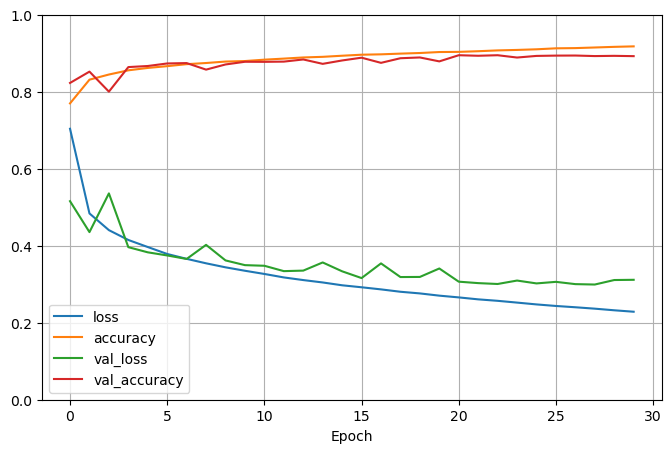

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

**IMPORTANTE**

+ Percebemos que as acurácias de treinamento e de validação aumentam durante o treinamento, enquanto as perdas de treinamento e validação diminuem. 


+ Além disso, as curvas de validação são bastante próximas das curvas de treinamento, o que significa que não há muito sobreajuste. 


+ Podemos dizer que o modelo ainda não convergiu completamente, pois a perda de validação ainda está diminuindo (não convergiu), então nós provavelmente devemos continuar o treinamento.
    + Para continuar o treinamento, basta chamar o método `fit()` novamente, já que Keras continua treinando de onde parou.
    + A acurácia no conjunto de validação deve superar os 89% com aproximadamente 50 épocas.
    
  
+ Se não estivermos satisfeitos com o desempenho do modelo, devemos **ajustar os hiperparâmetros** do modelo, por exemplo, o **número de camadas**, o **número de neurônios por camada**, os **tipos de funções de ativação** que usamos para cada camada oculta, o **número das épocas de treinamento**, o **tamanho do mini-batch**.
    + O tamanho do mini-batch pode ser definido no método `fit()` usando o argumento `batch_size`, cujo valor padrão é 32.

### Fazendo predições com o modelo treinado

+ Usamos o método `predict()` do modelo para fazer predições em novos exemplos. 
    + Usaremos apenas os 3 primeiros exemplos do conjunto de teste.
    + Esse é o conjunto normalmente usado para se avaliar o grau de generalização do modelo.

In [11]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 67ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**IMPORTANTE**

+ Como pode ser visto, para cada exemplo o modelo estima uma probabilidade por classe, da classe 0 à classe 9. 


+ Por exemplo, para a primeira imagem ele estima que 
    + a probabilidade da classe 9 (`Ankle boot`) é de 97%, 
    + a probabilidade da classe 7 (`Sneaker`) é de 2%, 
    + a probabilidade da classe 5 (`Sandal`) é de 1%, 
    + e as demais classes têm probabilidades desprezíveis (`round(2)`). 